In [1]:
# %pip install tensorflow

In [29]:
import pandas as pd
import data_config as cfg

import pandas as pd

import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import r2_score

### Data Collection. 
The dataset includes detailed information on resale transactions of HDB flats between January 1, 2017, and March 30, 2024. The dataset contains 180,154 rows and 11 columns and was downloaded on May 23, 2024. 

**Dataset URL**: [HDB Resale Prices](https://beta.data.gov.sg/datasets/d_8b84c4ee58e3cfc0ece0d773c8ca6abc/view) 
**HDB RPI URL**:[HDB Resale Prices Index](https://www.hdb.gov.sg/residential/selling-a-flat/overview/resale-statistics)

(180154, 11) (175672, 15) (175672, 52)


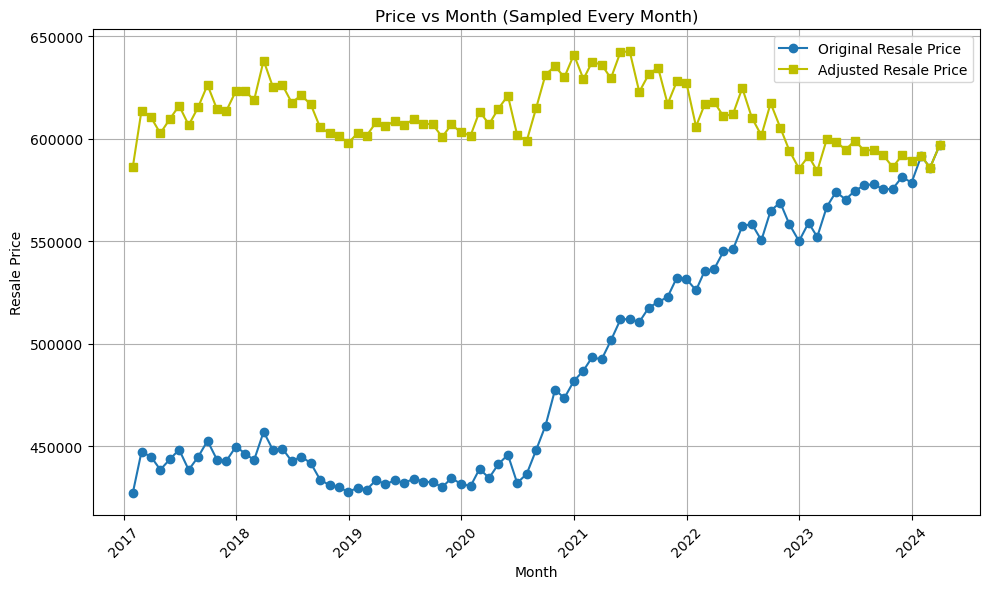

In [3]:
df_raw = pd.read_csv('./data/SGHDB2017-2024.csv')
cfg.save_dataset_info(df_raw, fname='dataset_info.csv')

df = cfg.adjust_resale_price(df_raw, cut_off_date='2024-04-01')
cfg.visualize_adjusted_price(df[['month', 'resale_price', 'adjusted_price']].copy(), fname='adjusted_price.png')

df_clean = cfg.preprocess_data(df)
print(df_raw.shape, df.shape, df_clean.shape)
df_clean.to_csv('./data/SGHDB2017-2024_clean.csv', index=False)

Install Required Libraries: 
Ensure you have the necessary libraries installed. You can install them using pip if they are not already installed.
```sgh 
pip install tensorflow pandas scikit-learn
```

### Step 1: 
The project starts by importing the pandas library and loading a cleaned CSV file named {SGHDB2017-2024_clean.csv} into a Pandas DataFrame $df$. Then, the {adjusted_price} column, which represents the housing prices to be predicted, is extracted and stored in the variable $y$ and the remaining columns, which serve as features for the model, are stored in the variable $X$.

In [4]:
# Step 1: Load the data
df = pd.read_csv('./data/SGHDB2017-2024_clean.csv')
y = df['adjusted_price'].values   # Target
X = df.drop(columns = 'adjusted_price')  # Features

### Step 2: Prepare the Data:
The dataset is well maintained and prepared by the Singapore government's open data portal. There is no missing data, which simplifies the preprocessing steps. 
Load your dataset and prepare it for training. This includes splitting it into training and testing sets and normalizing the features.

In [5]:
# Step 2: Prepare the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize continuous features
continuous_columns = ['flat_type', 'floor_area_sqm',  'floor', 'remaining_lease_months']
binary_columns = df.columns.difference(continuous_columns + ['adjusted_price']).tolist()
scaler = StandardScaler()
X_train_continuous = scaler.fit_transform(X_train[continuous_columns])
X_test_continuous = scaler.transform(X_test[continuous_columns])

# Combine scaled continuous features and binary features
X_train = np.hstack([X_train_continuous, X_train[binary_columns].values])
X_test = np.hstack([X_test_continuous, X_test[binary_columns].values])

In [6]:
X_train.shape

(122970, 51)

In [7]:
X_test.shape

(52702, 51)

In [8]:
for column in binary_columns:
    print(f"Unique values in column '{column}':")
    print(df[column].unique())
    print() 

Unique values in column 'flat_model_2-room':
[0. 1.]

Unique values in column 'flat_model_3Gen':
[0. 1.]

Unique values in column 'flat_model_Adjoined flat':
[0. 1.]

Unique values in column 'flat_model_Apartment':
[0. 1.]

Unique values in column 'flat_model_DBSS':
[0. 1.]

Unique values in column 'flat_model_Improved':
[1. 0.]

Unique values in column 'flat_model_Improved-Maisonette':
[0. 1.]

Unique values in column 'flat_model_Maisonette':
[0. 1.]

Unique values in column 'flat_model_Model A':
[0. 1.]

Unique values in column 'flat_model_Model A-Maisonette':
[0. 1.]

Unique values in column 'flat_model_Model A2':
[0. 1.]

Unique values in column 'flat_model_Multi Generation':
[0. 1.]

Unique values in column 'flat_model_New Generation':
[0. 1.]

Unique values in column 'flat_model_Premium Apartment':
[0. 1.]

Unique values in column 'flat_model_Premium Apartment Loft':
[0. 1.]

Unique values in column 'flat_model_Premium Maisonette':
[0. 1.]

Unique values in column 'flat_model_Sim

In [9]:
df[binary_columns].shape

(175672, 47)

In [10]:
for col in binary_columns:
    print(col, df[col].dtype, df[col].unique())


flat_model_2-room float64 [0. 1.]
flat_model_3Gen float64 [0. 1.]
flat_model_Adjoined flat float64 [0. 1.]
flat_model_Apartment float64 [0. 1.]
flat_model_DBSS float64 [0. 1.]
flat_model_Improved float64 [1. 0.]
flat_model_Improved-Maisonette float64 [0. 1.]
flat_model_Maisonette float64 [0. 1.]
flat_model_Model A float64 [0. 1.]
flat_model_Model A-Maisonette float64 [0. 1.]
flat_model_Model A2 float64 [0. 1.]
flat_model_Multi Generation float64 [0. 1.]
flat_model_New Generation float64 [0. 1.]
flat_model_Premium Apartment float64 [0. 1.]
flat_model_Premium Apartment Loft float64 [0. 1.]
flat_model_Premium Maisonette float64 [0. 1.]
flat_model_Simplified float64 [0. 1.]
flat_model_Standard float64 [0. 1.]
flat_model_Terrace float64 [0. 1.]
flat_model_Type S1 float64 [0. 1.]
flat_model_Type S2 float64 [0. 1.]
town_ANG MO KIO float64 [1. 0.]
town_BEDOK float64 [0. 1.]
town_BISHAN float64 [0. 1.]
town_BUKIT BATOK float64 [0. 1.]
town_BUKIT MERAH float64 [0. 1.]
town_BUKIT PANJANG float64 

### Step 3: 
This step defines a function create_regression_model that constructs a feedforward neural network model for regression using TensorFlow's Keras API. 

In [11]:
def create_regression_model(input_shape, params={}):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(shape=input_shape),    
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')

    return model

In [85]:
def create_regression_model_modified(input_shape, params={}):
    model_modified = tf.keras.Sequential([
        tf.keras.layers.InputLayer(shape=input_shape),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    model_modified.compile(optimizer='adam', loss='mean_squared_error')

    return model_modified

- 256 -> 128 -> 64 = degrade, 
- 128 -> 64 -> 32 = tiny bit improve,
- 256 -> 128 -> 64 -> 32 -> 16 = tiny bit improve,
- 256 -> 128 -> 64 -> 32 -> 16 -> 8 = degrade

- 128 -> 128 -> 64 -> 64 -> 32 -> 32 = not much,
- 128 -> 128 -> 64 -> 64 -> 32 -> 32 = tiny bit,

### Step 4: 
The model is trained using the training data  (\(X_{\text{train}}\) and \(y_{\text{train}}\)). The training process runs for 10 epochs (def: \ref{def:epoch}) with a batch size of 32. 

In [17]:
# Step 4: Create and train the model
model = create_regression_model(input_shape=[X_train.shape[1]])
history = model.fit(X_train, y_train, epochs=10, batch_size=32, 
                    validation_data=(X_test, y_test), verbose=0)

In [83]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,629 (25.90 KB)

 Trainable params: 2,209 (8.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,420 (17.27 KB)

In [53]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

In [109]:
# Step 4: Create and train the modified model
model_modified = create_regression_model_modified(input_shape=[X_train.shape[1]])
history_modified = model_modified.fit(
    X_train,
    y_train,
    epochs=30, 
    batch_size=32, 
    validation_data=(X_test, y_test),
    # callbacks = [early_stopping], 
    verbose=0)

In [110]:
model_modified.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_57 (Dense)                │ (None, 256)            │        13,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 171,269 (669.02 KB)

 Trainable params: 57,089 (223.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 114,180 (446.02 KB)

<!-- - initial model archi, epoch = 20 = 0.82 -> 0.87
- 64/32/16, epoch = 20 = 0.82 -> 0.87
- 64/32/16/8, epoch = 20 = 0.82 -> 0.87
- 128/64/32/16/8, epoch = 20 = 0.82 -> 0.87

learning curve shows good fit. -->

<!-- called the wrong model training method invalid -->

Training time is about the same in my machine around 16s for 10 epochs, 31s for 20 epochs, 48s for 30 epochs 1m 20s for 50 epochs.

<!-- - initial model archi, epoch = 30 = 0.82 -> 0.89: learning curve shows good fit.
- 64/32/16, epoch = 30 = 0.82 -> 0.89
- 128/64/32/16, epoch = 30 = 0.82 -> 0.89
- 128/64/32/16/8, epoch = 30 = 0.82 -> 0.89 --> 
<!-- called wrong training method -->

## initial model archi 
- epoch = 50 = 0.82 -> 0.9

## 256/128/64/32/16
- epoch = 10 = 0.92 
- epoch = 20 = 0.93/0.92 
- epoch = 50 = 0.93

In [19]:
def plot_learning_curves(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.show()

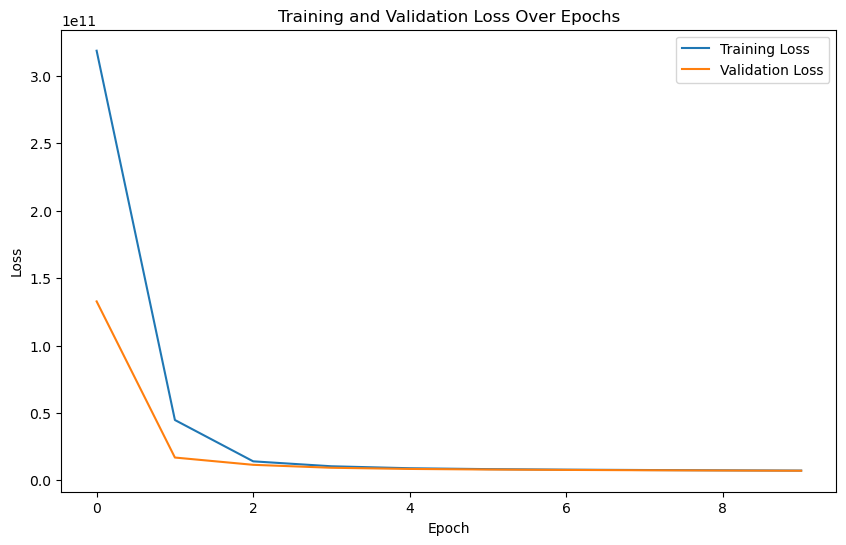

In [33]:
plot_learning_curves(history)

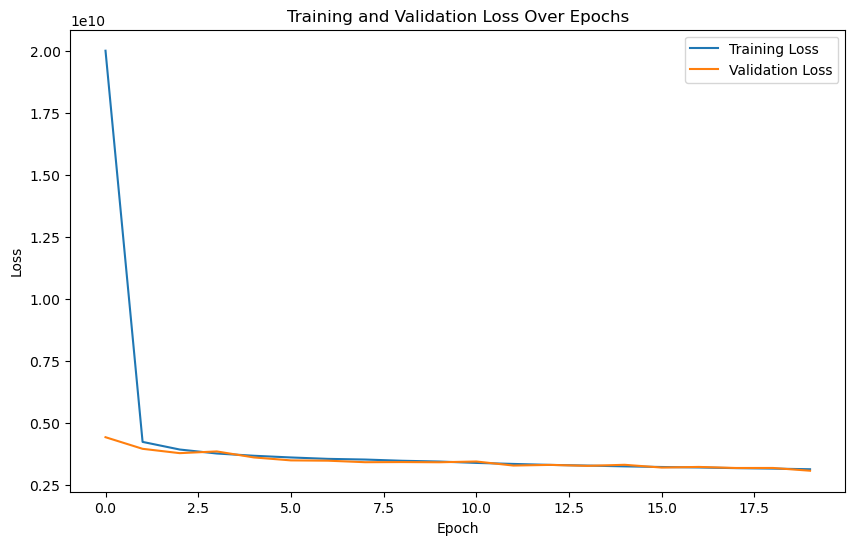

In [105]:
plot_learning_curves(history_modified)

### Step 5:
In the last step, the model is evaluated using various performance metrics and saves the evaluation results to a CSV file.

In [21]:
# Step 4: Evaluate the model
df_results = pd.DataFrame(columns=['Train', 'Test'])

y_pred = model.predict(X_train)
df_results.loc['Root Mean Squared Error', 'Train'] = np.sqrt(mean_squared_error(y_train, y_pred))
df_results.loc['Mean Aboslute Error', 'Train'] = mean_absolute_error(y_train, y_pred)
df_results.loc['Mean Aboslute Percentage Error', 'Train'] = mean_absolute_percentage_error(y_train, y_pred)*100
df_results.loc['R2 score', 'Train'] = r2_score(y_train, y_pred)

y_pred = model.predict(X_test)
df_results.loc['Root Mean Squared Error', 'Test'] = np.sqrt(mean_squared_error(y_test, y_pred))
df_results.loc['Mean Aboslute Error', 'Test'] = mean_absolute_error(y_test, y_pred)
df_results.loc['Mean Aboslute Percentage Error', 'Test'] = mean_absolute_percentage_error(y_test, y_pred)*100
df_results.loc['R2 score', 'Test'] = r2_score(y_test, y_pred)

df_results = df_results.astype('Float64').round(2)
df_results.to_csv('./data/model_evaluation.csv')

3843/3843 ━━━━━━━━━━━━━━━━━━━━ 1s 247us/step
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step


In [106]:
df_results_modified = pd.DataFrame(columns=['Train_modified', 'Test_modified'])

y_pred_modified = model_modified.predict(X_train)
df_results_modified.loc['Root Mean Squared Error', 'Train_modified'] = np.sqrt(mean_squared_error(y_train, y_pred_modified))
df_results_modified.loc['Mean Aboslute Error', 'Train_modified'] = mean_absolute_error(y_train, y_pred_modified)
df_results_modified.loc['Mean Aboslute Percentage Error', 'Train_modified'] = mean_absolute_percentage_error(y_train, y_pred_modified)*100
df_results_modified.loc['R2 score', 'Train_modified'] = r2_score(y_train, y_pred_modified)

y_pred_modified = model_modified.predict(X_test)
df_results_modified.loc['Root Mean Squared Error', 'Test_modified'] = np.sqrt(mean_squared_error(y_test, y_pred_modified))
df_results_modified.loc['Mean Aboslute Error', 'Test_modified'] = mean_absolute_error(y_test, y_pred_modified)
df_results_modified.loc['Mean Aboslute Percentage Error', 'Test_modified'] = mean_absolute_percentage_error(y_test, y_pred_modified)*100
df_results_modified.loc['R2 score', 'Test_modified'] = r2_score(y_test, y_pred_modified)

df_results_modified = df_results_modified.astype('Float64').round(2)
df_results_modified.to_csv('./data/model_evaluation_modified.csv')

3843/3843 ━━━━━━━━━━━━━━━━━━━━ 1s 333us/step
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 1s 325us/step


In [107]:
print(df_results)
print(df_results_modified)

                                   Train      Test
Root Mean Squared Error         84701.67  84666.58
Mean Aboslute Error             63627.76  63541.28
Mean Aboslute Percentage Error     10.57     10.58
R2 score                            0.82      0.82
                                Train_modified  Test_modified
Root Mean Squared Error               55190.45       55536.02
Mean Aboslute Error                   39579.46       39698.81
Mean Aboslute Percentage Error             6.4           6.43
R2 score                                  0.93           0.92


In [24]:
def plot_predictions(y_actual, y_predicted):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_actual, y_predicted, color='blue')
    plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'r--')
    plt.xlabel('Actual value')
    plt.ylabel('Predicted value')
    plt.title('Predicted vs Actual')
    plt.show()

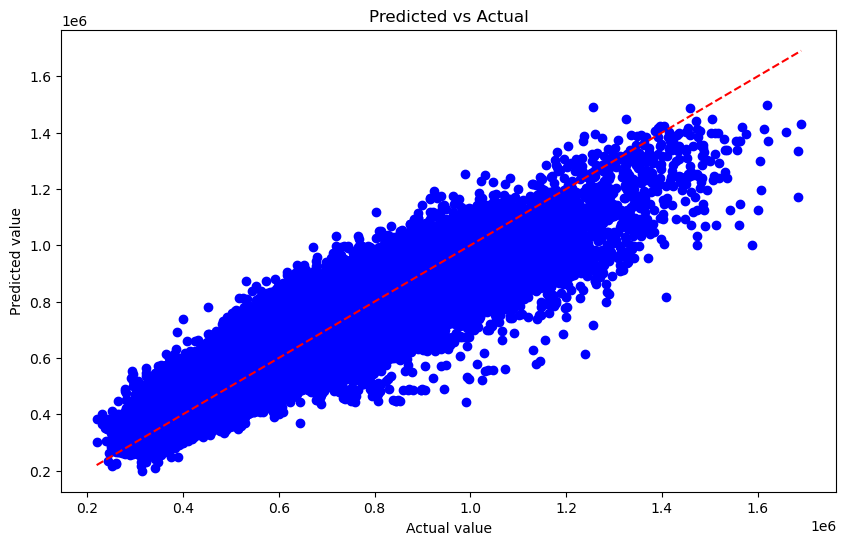

In [25]:
plot_predictions(y_test, y_pred)

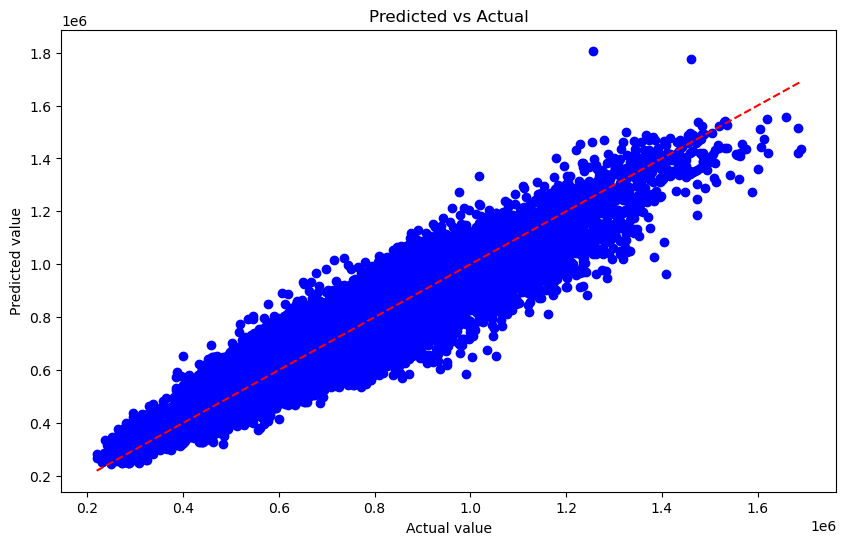

In [108]:
plot_predictions(y_test, y_pred_modified)